In [1]:
import tensorflow as tf

print(tf.__version__)

from tensorflow.keras.models                import Sequential, Model
from tensorflow.keras.layers                import *
from tensorflow.keras.preprocessing.image   import ImageDataGenerator
from tensorflow.keras.utils                 import to_categorical
from tensorflow.keras.optimizers            import SGD, RMSprop, Adam, Adagrad, Adadelta

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
import random
# import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import sklearn
import scipy
import skimage
from skimage.transform import resize
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

2023-09-16 16:36:33.064245: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-16 16:36:36.361217: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-16 16:36:36.361404: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

2.11.0


In [2]:
# !git clone https://github.com/EricMartinezIllamola/asl-alphabet.git

In [3]:
# !pip install split-folders 

In [4]:
# import splitfolders
# import os

In [5]:
# path = "asl-alphabet/asl-alphabet"

# splitfolders.ratio(path, seed=777, output="Train-Validation-Test-Dataset", ratio=(0.6, 0.2, 0.2))

In [6]:
train_path = "Train-Validation-Test-Dataset/train"
val_path = "Train-Validation-Test-Dataset/val"
test_path = "Train-Validation-Test-Dataset/test"

In [7]:
tf.config.experimental.list_physical_devices()

2023-09-16 16:36:40.479468: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-16 16:36:40.493753: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-16 16:36:40.496554: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
tf.test.is_built_with_cuda()

True

In [9]:
from tensorflow.keras.preprocessing.image   import ImageDataGenerator

##Clasificamos las imagenes
bs = 64 #bach size
k = 2
# Generador de imágenes de entrenamiento.
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=(0.3),
        zoom_range=(0.3),
        width_shift_range=(0.2),
        height_shift_range=(0.2),
        # validation_split = 0.2,
        brightness_range=(0.05,0.85),
        horizontal_flip=False)

# Carga de imágenes al generador de entrenamiento desde directorio.
train_generator = train_datagen.flow_from_directory(
        train_path,
        class_mode='categorical',
        shuffle=True,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'training',
        batch_size=bs)

valid_generator = train_datagen.flow_from_directory(
        val_path,
        class_mode='categorical',
        shuffle=False,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'validation',
        batch_size=bs)

test_generator = train_datagen.flow_from_directory(
        test_path,
        class_mode='categorical',
        shuffle=False,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'validation',
        batch_size=bs)

Found 44695 images belonging to 24 classes.
Found 14892 images belonging to 24 classes.
Found 14921 images belonging to 24 classes.


In [10]:
#Visualizamos la estructura del modelo que vamos a utilizar
model = tf.keras.applications.VGG19()
model.summary()
print(len(model.layers))

2023-09-16 16:36:47.410811: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-16 16:36:47.413169: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-16 16:36:47.416696: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-16 16:36:47.419569: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
##DEFINIMOS EL MODELO
num_classes = 24
epochs = 50

# VGG19
# Importamos el modelo que queremos utilizar con los argumentos que queremos
VGG19_model = tf.keras.applications.VGG19(input_shape=(28*k,28*k,3),
                                          include_top=False,
                                          weights='imagenet')

print(len(VGG19_model.layers))
#Congelamos  las 6 primeras caps del modelo para proceder a entrenar las demás
for layer in VGG19_model.layers[:6]:
  layer.trainable = False

# Creamos un nuevo modelo vacio.
model = tf.keras.Sequential()

# Añadimos el modelo preentrenado como si se tratase de una capa.
model.add(VGG19_model)

# Continuamos añadiendo más capas que sí serán entrenadas...
from tensorflow.keras import regularizers
model.add(Flatten())
model.add(Dense(512, kernel_regularizer=regularizers.l2(0.01), activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation = 'softmax'))

22


In [12]:
## EJECUCION DEL MODELO
# with tf.device("/CPU:0"):
# with tf.device("/GPU:0"):
model.compile(loss="categorical_crossentropy", 
              optimizer= SGD(learning_rate=0.001),
              metrics=['accuracy'])

#Agregamos un callback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

checkpointer = ModelCheckpoint(filepath='model-02', verbose=1, save_best_only=True,
                               monitor = 'accuracy', mode = 'max')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=3, min_lr=0.000001)

history= model.fit(train_generator, callbacks = [reduce_lr, checkpointer], epochs=epochs)

Epoch 1/50


2023-09-16 16:36:53.426046: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200
2023-09-16 16:36:55.949916: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x562c935a5620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-16 16:36:55.949969: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-09-16 16:36:56.031027: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


699/699 [==============================] - ETA: 0s - loss: 7.9999 - accuracy: 0.1240
Epoch 1: accuracy improved from -inf to 0.12397, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


699/699 [==============================] - 97s 130ms/step - loss: 7.9999 - accuracy: 0.1240 - lr: 0.0010
Epoch 2/50
699/699 [==============================] - ETA: 0s - loss: 6.5769 - accuracy: 0.4875
Epoch 2: accuracy improved from 0.12397 to 0.48746, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


699/699 [==============================] - 91s 130ms/step - loss: 6.5769 - accuracy: 0.4875 - lr: 0.0010
Epoch 3/50
699/699 [==============================] - ETA: 0s - loss: 5.7053 - accuracy: 0.7066
Epoch 3: accuracy improved from 0.48746 to 0.70661, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


699/699 [==============================] - 91s 130ms/step - loss: 5.7053 - accuracy: 0.7066 - lr: 0.0010
Epoch 4/50
699/699 [==============================] - ETA: 0s - loss: 5.2966 - accuracy: 0.7959
Epoch 4: accuracy improved from 0.70661 to 0.79593, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


699/699 [==============================] - 91s 130ms/step - loss: 5.2966 - accuracy: 0.7959 - lr: 0.0010
Epoch 5/50
699/699 [==============================] - ETA: 0s - loss: 5.0429 - accuracy: 0.8336
Epoch 5: accuracy improved from 0.79593 to 0.83363, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


699/699 [==============================] - 91s 130ms/step - loss: 5.0429 - accuracy: 0.8336 - lr: 0.0010
Epoch 6/50
699/699 [==============================] - ETA: 0s - loss: 4.8272 - accuracy: 0.8634
Epoch 6: accuracy improved from 0.83363 to 0.86343, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


699/699 [==============================] - 91s 130ms/step - loss: 4.8272 - accuracy: 0.8634 - lr: 0.0010
Epoch 7/50
699/699 [==============================] - ETA: 0s - loss: 4.6525 - accuracy: 0.8797
Epoch 7: accuracy improved from 0.86343 to 0.87970, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


699/699 [==============================] - 90s 128ms/step - loss: 4.6525 - accuracy: 0.8797 - lr: 0.0010
Epoch 8/50
699/699 [==============================] - ETA: 0s - loss: 4.4939 - accuracy: 0.8930
Epoch 8: accuracy improved from 0.87970 to 0.89303, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


699/699 [==============================] - 89s 128ms/step - loss: 4.4939 - accuracy: 0.8930 - lr: 0.0010
Epoch 9/50
699/699 [==============================] - ETA: 0s - loss: 4.3463 - accuracy: 0.9027
Epoch 9: accuracy improved from 0.89303 to 0.90274, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


699/699 [==============================] - 89s 128ms/step - loss: 4.3463 - accuracy: 0.9027 - lr: 0.0010
Epoch 10/50
699/699 [==============================] - ETA: 0s - loss: 4.2080 - accuracy: 0.9133
Epoch 10: accuracy improved from 0.90274 to 0.91326, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


699/699 [==============================] - 90s 128ms/step - loss: 4.2080 - accuracy: 0.9133 - lr: 0.0010
Epoch 11/50
699/699 [==============================] - ETA: 0s - loss: 4.0810 - accuracy: 0.9175
Epoch 11: accuracy improved from 0.91326 to 0.91753, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


699/699 [==============================] - 89s 128ms/step - loss: 4.0810 - accuracy: 0.9175 - lr: 0.0010
Epoch 12/50
699/699 [==============================] - ETA: 0s - loss: 3.9523 - accuracy: 0.9256
Epoch 12: accuracy improved from 0.91753 to 0.92556, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


699/699 [==============================] - 89s 127ms/step - loss: 3.9523 - accuracy: 0.9256 - lr: 0.0010
Epoch 13/50
699/699 [==============================] - ETA: 0s - loss: 3.8344 - accuracy: 0.9306
Epoch 13: accuracy improved from 0.92556 to 0.93060, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


699/699 [==============================] - 89s 128ms/step - loss: 3.8344 - accuracy: 0.9306 - lr: 0.0010
Epoch 14/50
699/699 [==============================] - ETA: 0s - loss: 3.7246 - accuracy: 0.9337
Epoch 14: accuracy improved from 0.93060 to 0.93368, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


699/699 [==============================] - 89s 127ms/step - loss: 3.7246 - accuracy: 0.9337 - lr: 0.0010
Epoch 15/50
699/699 [==============================] - ETA: 0s - loss: 3.6247 - accuracy: 0.9355
Epoch 15: accuracy improved from 0.93368 to 0.93545, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


699/699 [==============================] - 89s 127ms/step - loss: 3.6247 - accuracy: 0.9355 - lr: 0.0010
Epoch 16/50
699/699 [==============================] - ETA: 0s - loss: 3.5168 - accuracy: 0.9381
Epoch 16: accuracy improved from 0.93545 to 0.93811, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


699/699 [==============================] - 88s 126ms/step - loss: 3.5168 - accuracy: 0.9381 - lr: 0.0010
Epoch 17/50
699/699 [==============================] - ETA: 0s - loss: 3.4137 - accuracy: 0.9429
Epoch 17: accuracy improved from 0.93811 to 0.94288, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


699/699 [==============================] - 89s 127ms/step - loss: 3.4137 - accuracy: 0.9429 - lr: 0.0010
Epoch 18/50
699/699 [==============================] - ETA: 0s - loss: 3.3212 - accuracy: 0.9452
Epoch 18: accuracy improved from 0.94288 to 0.94516, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


699/699 [==============================] - 88s 126ms/step - loss: 3.3212 - accuracy: 0.9452 - lr: 0.0010
Epoch 19/50
699/699 [==============================] - ETA: 0s - loss: 3.2291 - accuracy: 0.9467
Epoch 19: accuracy improved from 0.94516 to 0.94673, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


699/699 [==============================] - 88s 126ms/step - loss: 3.2291 - accuracy: 0.9467 - lr: 0.0010
Epoch 20/50
699/699 [==============================] - ETA: 0s - loss: 3.1307 - accuracy: 0.9506
Epoch 20: accuracy improved from 0.94673 to 0.95058, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


699/699 [==============================] - 88s 126ms/step - loss: 3.1307 - accuracy: 0.9506 - lr: 0.0010
Epoch 21/50
699/699 [==============================] - ETA: 0s - loss: 3.0512 - accuracy: 0.9505
Epoch 21: accuracy did not improve from 0.95058
699/699 [==============================] - 85s 122ms/step - loss: 3.0512 - accuracy: 0.9505 - lr: 0.0010
Epoch 22/50
699/699 [==============================] - ETA: 0s - loss: 2.9618 - accuracy: 0.9534
Epoch 22: accuracy improved from 0.95058 to 0.95344, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


699/699 [==============================] - 89s 127ms/step - loss: 2.9618 - accuracy: 0.9534 - lr: 0.0010
Epoch 23/50
699/699 [==============================] - ETA: 0s - loss: 2.8777 - accuracy: 0.9558
Epoch 23: accuracy improved from 0.95344 to 0.95577, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


699/699 [==============================] - 89s 128ms/step - loss: 2.8777 - accuracy: 0.9558 - lr: 0.0010
Epoch 24/50
699/699 [==============================] - ETA: 0s - loss: 2.7985 - accuracy: 0.9570
Epoch 24: accuracy improved from 0.95577 to 0.95700, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


699/699 [==============================] - 89s 127ms/step - loss: 2.7985 - accuracy: 0.9570 - lr: 0.0010
Epoch 25/50
699/699 [==============================] - ETA: 0s - loss: 2.7247 - accuracy: 0.9579
Epoch 25: accuracy improved from 0.95700 to 0.95791, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


699/699 [==============================] - 89s 127ms/step - loss: 2.7247 - accuracy: 0.9579 - lr: 0.0010
Epoch 26/50
699/699 [==============================] - ETA: 0s - loss: 2.6461 - accuracy: 0.9604
Epoch 26: accuracy improved from 0.95791 to 0.96044, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


699/699 [==============================] - 90s 128ms/step - loss: 2.6461 - accuracy: 0.9604 - lr: 0.0010
Epoch 27/50
699/699 [==============================] - ETA: 0s - loss: 2.5746 - accuracy: 0.9603
Epoch 27: accuracy did not improve from 0.96044
699/699 [==============================] - 87s 125ms/step - loss: 2.5746 - accuracy: 0.9603 - lr: 0.0010
Epoch 28/50
699/699 [==============================] - ETA: 0s - loss: 2.5010 - accuracy: 0.9625
Epoch 28: accuracy improved from 0.96044 to 0.96248, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


699/699 [==============================] - 91s 131ms/step - loss: 2.5010 - accuracy: 0.9625 - lr: 0.0010
Epoch 29/50
699/699 [==============================] - ETA: 0s - loss: 2.4352 - accuracy: 0.9627
Epoch 29: accuracy improved from 0.96248 to 0.96270, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


699/699 [==============================] - 89s 128ms/step - loss: 2.4352 - accuracy: 0.9627 - lr: 0.0010
Epoch 30/50
699/699 [==============================] - ETA: 0s - loss: 2.3662 - accuracy: 0.9652
Epoch 30: accuracy improved from 0.96270 to 0.96519, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


699/699 [==============================] - 90s 129ms/step - loss: 2.3662 - accuracy: 0.9652 - lr: 0.0010
Epoch 31/50
699/699 [==============================] - ETA: 0s - loss: 2.3008 - accuracy: 0.9660
Epoch 31: accuracy improved from 0.96519 to 0.96599, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


699/699 [==============================] - 90s 128ms/step - loss: 2.3008 - accuracy: 0.9660 - lr: 0.0010
Epoch 32/50
699/699 [==============================] - ETA: 0s - loss: 2.2445 - accuracy: 0.9634
Epoch 32: accuracy did not improve from 0.96599
699/699 [==============================] - 84s 120ms/step - loss: 2.2445 - accuracy: 0.9634 - lr: 0.0010
Epoch 33/50
699/699 [==============================] - ETA: 0s - loss: 2.1800 - accuracy: 0.9659
Epoch 33: accuracy did not improve from 0.96599
699/699 [==============================] - 85s 122ms/step - loss: 2.1800 - accuracy: 0.9659 - lr: 0.0010
Epoch 34/50
699/699 [==============================] - ETA: 0s - loss: 2.1223 - accuracy: 0.9668
Epoch 34: accuracy improved from 0.96599 to 0.96680, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


699/699 [==============================] - 89s 128ms/step - loss: 2.1223 - accuracy: 0.9668 - lr: 0.0010
Epoch 35/50
699/699 [==============================] - ETA: 0s - loss: 2.0612 - accuracy: 0.9687
Epoch 35: accuracy improved from 0.96680 to 0.96872, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


699/699 [==============================] - 90s 128ms/step - loss: 2.0612 - accuracy: 0.9687 - lr: 0.0010
Epoch 36/50
699/699 [==============================] - ETA: 0s - loss: 2.0094 - accuracy: 0.9681
Epoch 36: accuracy did not improve from 0.96872
699/699 [==============================] - 84s 121ms/step - loss: 2.0094 - accuracy: 0.9681 - lr: 0.0010
Epoch 37/50
699/699 [==============================] - ETA: 0s - loss: 1.9524 - accuracy: 0.9689
Epoch 37: accuracy improved from 0.96872 to 0.96890, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


699/699 [==============================] - 89s 127ms/step - loss: 1.9524 - accuracy: 0.9689 - lr: 0.0010
Epoch 38/50
699/699 [==============================] - ETA: 0s - loss: 1.9040 - accuracy: 0.9693
Epoch 38: accuracy improved from 0.96890 to 0.96926, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


699/699 [==============================] - 89s 128ms/step - loss: 1.9040 - accuracy: 0.9693 - lr: 0.0010
Epoch 39/50
699/699 [==============================] - ETA: 0s - loss: 1.8502 - accuracy: 0.9689
Epoch 39: accuracy did not improve from 0.96926
699/699 [==============================] - 84s 119ms/step - loss: 1.8502 - accuracy: 0.9689 - lr: 0.0010
Epoch 40/50
699/699 [==============================] - ETA: 0s - loss: 1.7957 - accuracy: 0.9719
Epoch 40: accuracy improved from 0.96926 to 0.97190, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


699/699 [==============================] - 89s 128ms/step - loss: 1.7957 - accuracy: 0.9719 - lr: 0.0010
Epoch 41/50
699/699 [==============================] - ETA: 0s - loss: 1.7459 - accuracy: 0.9732
Epoch 41: accuracy improved from 0.97190 to 0.97322, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


699/699 [==============================] - 89s 127ms/step - loss: 1.7459 - accuracy: 0.9732 - lr: 0.0010
Epoch 42/50
699/699 [==============================] - ETA: 0s - loss: 1.7031 - accuracy: 0.9719
Epoch 42: accuracy did not improve from 0.97322
699/699 [==============================] - 84s 120ms/step - loss: 1.7031 - accuracy: 0.9719 - lr: 0.0010
Epoch 43/50
699/699 [==============================] - ETA: 0s - loss: 1.6547 - accuracy: 0.9729
Epoch 43: accuracy did not improve from 0.97322
699/699 [==============================] - 84s 121ms/step - loss: 1.6547 - accuracy: 0.9729 - lr: 0.0010
Epoch 44/50
699/699 [==============================] - ETA: 0s - loss: 1.6116 - accuracy: 0.9726
Epoch 44: accuracy did not improve from 0.97322
699/699 [==============================] - 85s 121ms/step - loss: 1.6116 - accuracy: 0.9726 - lr: 0.0010
Epoch 45/50
699/699 [==============================] - ETA: 0s - loss: 1.5672 - accuracy: 0.9743
Epoch 45: accuracy improved from 0.97322 to 0.97

INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


699/699 [==============================] - 89s 127ms/step - loss: 1.5672 - accuracy: 0.9743 - lr: 0.0010
Epoch 46/50
699/699 [==============================] - ETA: 0s - loss: 1.5236 - accuracy: 0.9754
Epoch 46: accuracy improved from 0.97429 to 0.97539, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


699/699 [==============================] - 89s 127ms/step - loss: 1.5236 - accuracy: 0.9754 - lr: 0.0010
Epoch 47/50
699/699 [==============================] - ETA: 0s - loss: 1.4835 - accuracy: 0.9744
Epoch 47: accuracy did not improve from 0.97539
699/699 [==============================] - 85s 122ms/step - loss: 1.4835 - accuracy: 0.9744 - lr: 0.0010
Epoch 48/50
699/699 [==============================] - ETA: 0s - loss: 1.4463 - accuracy: 0.9747
Epoch 48: accuracy did not improve from 0.97539
699/699 [==============================] - 85s 121ms/step - loss: 1.4463 - accuracy: 0.9747 - lr: 0.0010
Epoch 49/50
699/699 [==============================] - ETA: 0s - loss: 1.4040 - accuracy: 0.9766
Epoch 49: accuracy improved from 0.97539 to 0.97657, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


699/699 [==============================] - 90s 128ms/step - loss: 1.4040 - accuracy: 0.9766 - lr: 0.0010
Epoch 50/50
699/699 [==============================] - ETA: 0s - loss: 1.3714 - accuracy: 0.9754
Epoch 50: accuracy did not improve from 0.97657
699/699 [==============================] - 84s 120ms/step - loss: 1.3714 - accuracy: 0.9754 - lr: 0.0010


In [13]:
preds_test = model.predict(test_generator)

234/234 [==============================] - 29s 122ms/step


In [14]:
evaluate_test = model.evaluate(test_generator)

234/234 [==============================] - 28s 120ms/step - loss: 1.3717 - accuracy: 0.9682


In [15]:
evaluate_test

[1.3717153072357178, 0.9682326912879944]

In [16]:
y_preds_test = np.array([np.argmax(x) for x in preds_test])
y_preds_test

array([18,  5, 18, ..., 23, 23, 23])

In [17]:
y_real_test = test_generator.classes
y_real_test

array([ 0,  0,  0, ..., 23, 23, 23], dtype=int32)

In [18]:
accuracy_test = accuracy_score(y_real_test, y_preds_test)
accuracy_test

0.9676965350847798

In [19]:
cm_test = confusion_matrix(y_real_test, y_preds_test)
cm_test

array([[598,   1,   3,   2,   0,   2,   0,   0,   1,   0,   0,   1,   0,
          0,   0,   0,   2,   2,   8,   0,   0,   0,   0,   0],
       [  1, 584,   1,   3,  10,   1,   0,   0,  13,   1,   0,   1,   0,
          1,   1,   0,   1,   0,   0,   3,   1,   1,   0,   0],
       [  0,   0, 624,   3,   2,   0,   0,   0,   0,   0,   0,   0,   0,
          2,   0,   2,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   1,   1, 614,   0,   0,   0,   0,   2,   1,   0,   0,   0,
          2,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   1,   1, 597,   2,   0,   0,  16,   0,   0,   1,   0,
          0,   1,   0,   1,  13,   3,   0,   0,   0,   1,   0],
       [  0,   0,   1,   0,   2, 612,   0,   0,   2,   2,   0,   0,   1,
          0,   0,   0,   1,   1,   0,   0,   0,   2,   0,   0],
       [  0,   0,   0,   0,   0,   0, 610,   2,   2,   1,   0,   0,   0,
          1,   1,   1,   1,   0,   0,   0,   0,   0,   2,   2],
       [  0,   0,   0,   0,   0,   0,  15

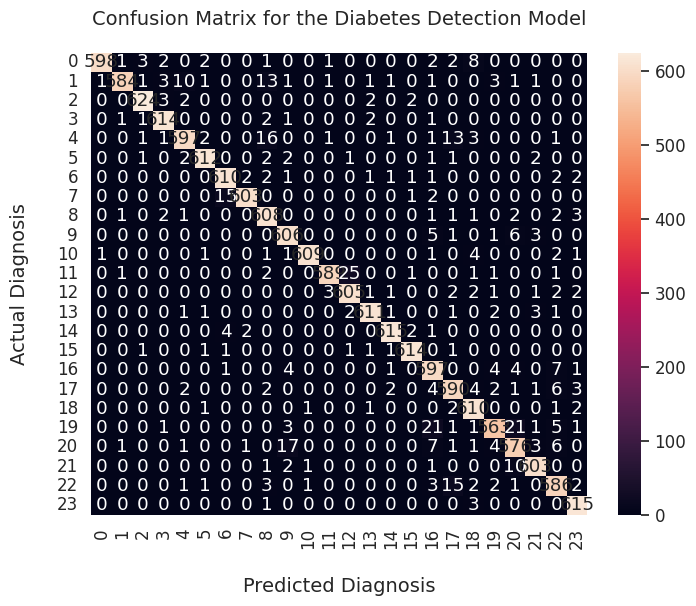

In [20]:
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm_test, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

plt.show()

In [21]:
preds_val = model.predict(valid_generator)

233/233 [==============================] - 29s 122ms/step


In [22]:
evaluate_val = model.evaluate(valid_generator)

233/233 [==============================] - 27s 117ms/step - loss: 1.3604 - accuracy: 0.9729


In [23]:
evaluate_val

[1.360392689704895, 0.9728713631629944]

In [24]:
y_preds_val = np.array([np.argmax(x) for x in preds_val])
y_preds_val

array([ 2,  1,  0, ..., 23, 23, 23])

In [25]:
y_real_val = valid_generator.classes
y_real_val

array([ 0,  0,  0, ..., 23, 23, 23], dtype=int32)

In [26]:
accuracy_val = accuracy_score(y_real_val, y_preds_val)
accuracy_val

0.9710582863282299

In [27]:
cm_val = confusion_matrix(y_real_val, y_preds_val)
cm_val

array([[596,   1,   1,   0,   8,   0,   0,   0,   0,   1,   0,   1,   0,
          0,   0,   0,   0,   1,   9,   0,   0,   0,   0,   0],
       [  0, 585,   0,   1,  14,   2,   0,   0,   9,   1,   0,   0,   0,
          0,   0,   0,   5,   0,   0,   1,   0,   1,   1,   1],
       [  0,   0, 629,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,
          1,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0],
       [  0,   1,   2, 613,   1,   0,   0,   0,   2,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0],
       [  2,   0,   0,   2, 600,   2,   0,   0,  12,   0,   0,   0,   1,
          2,   0,   0,   1,  11,   2,   0,   0,   0,   1,   1],
       [  0,   0,   0,   0,   1, 611,   2,   0,   3,   1,   0,   0,   0,
          0,   0,   0,   1,   0,   0,   0,   1,   2,   0,   0],
       [  0,   0,   0,   0,   0,   1, 614,   4,   0,   1,   0,   0,   0,
          0,   2,   1,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   1,  12

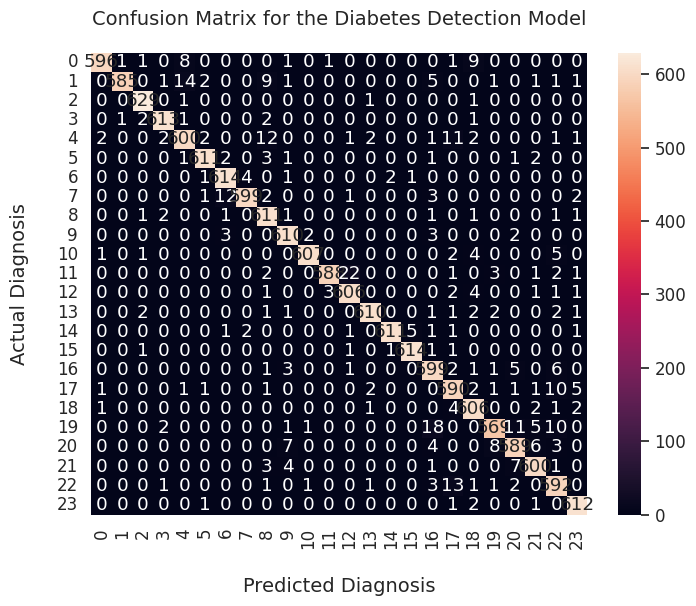

In [28]:
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm_val, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

plt.show()